In [ ]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Data from Social Competition Task
[Download dataset](http://neurotycho.brain.riken.jp/download/base/20100803S1_Social+Competition_K2_Toru+Yanagawa_csv_ECoG128-Eye9-Motion22-Event3.zip)

In [58]:
data = pd.read_csv('../data/Eye-Motion/ECoG.csv', header=0)

In [66]:
data_sample = data[:1000]

In [69]:
data_sample = data_sample.loc[:, :"ECoG_ch6"]

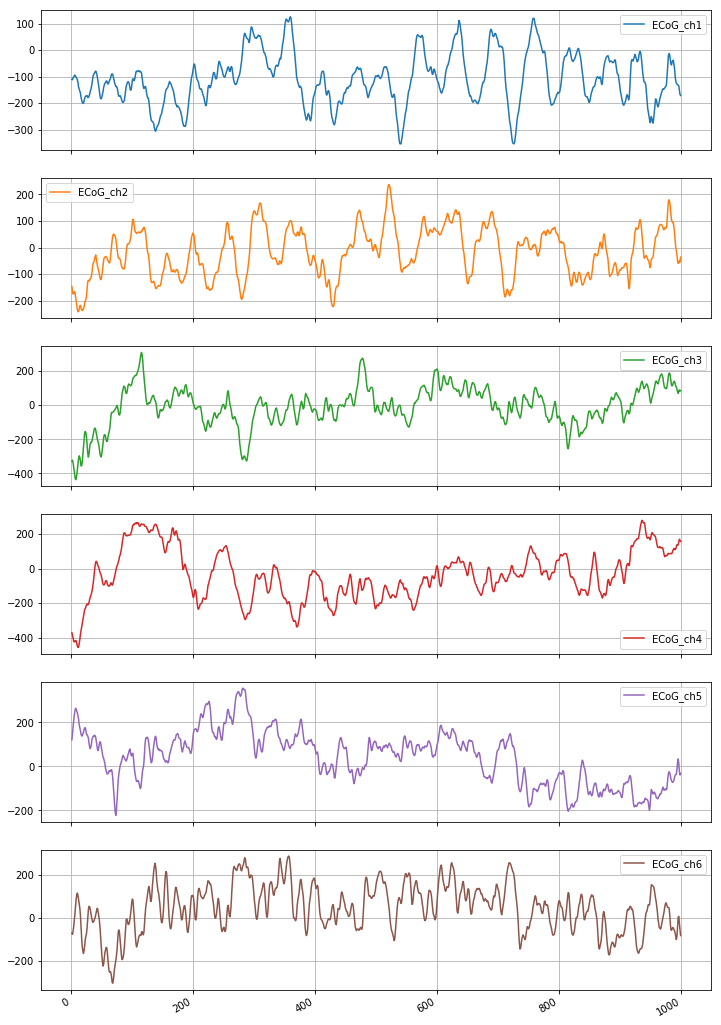

In [70]:
%matplotlib inline
data_sample.loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(12, 20), grid=True);

Небольшое усреднение по трем, рядом лежащим, точкам

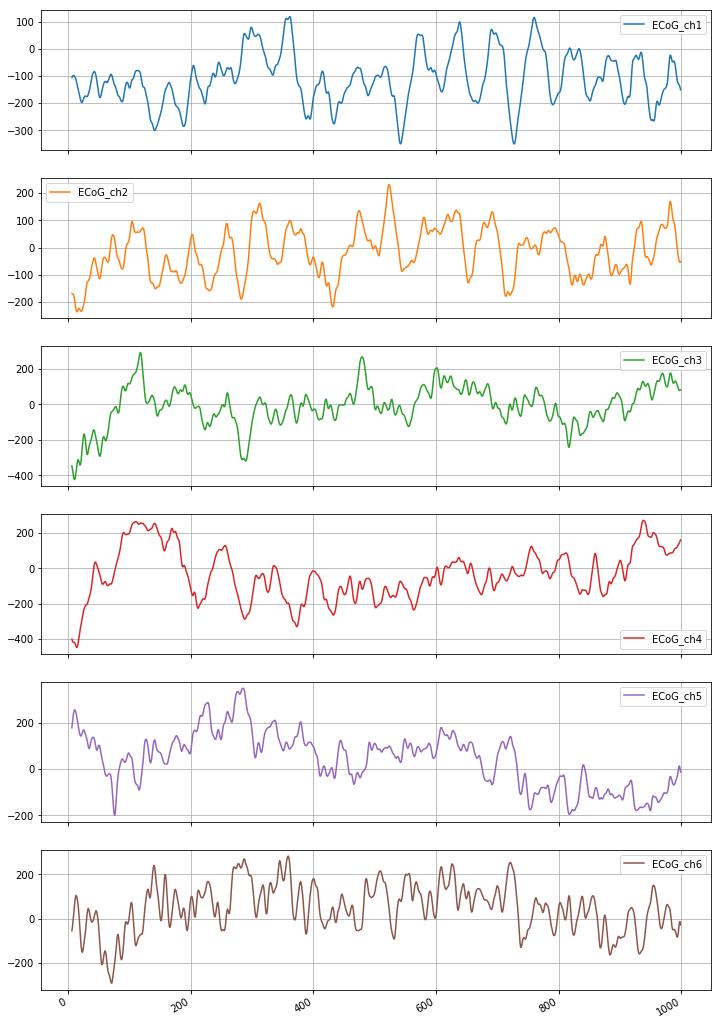

In [73]:
%matplotlib inline
data_sample.rolling(window=3).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(12, 20), grid=True);

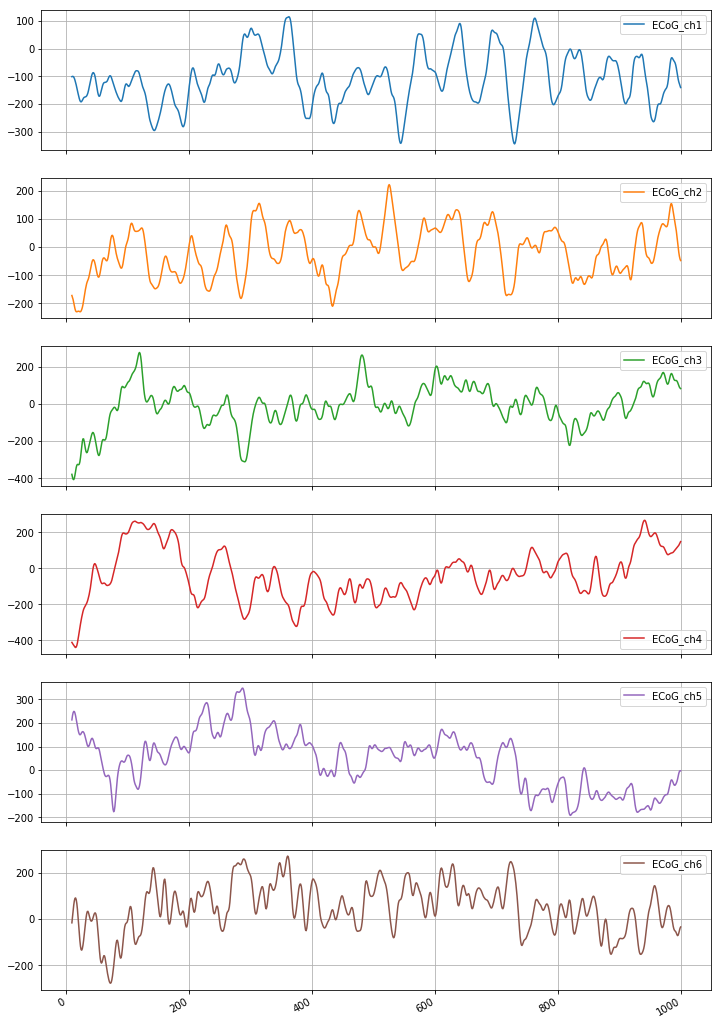

In [74]:
%matplotlib inline
data_sample
data_sample.rolling(window=6).mean().loc[:, "ECoG_ch1":].plot(subplots=True, figsize=(12, 20), grid=True);